In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from openTSNE import TSNE
from collections import Counter
from sklearn.decomposition import PCA

# Подготовка данных

In [2]:
data = np.load('qualifiers_track_1/data/ts_cut/ihb.npy')
data.shape

(320, 10, 246)

In [3]:
reshaped_data = data.reshape(320 * 10, 246)
experiment_ids = np.repeat(np.arange(1, 321), 10)
column_names = ['Experiment_ID'] + [f'Parameter_{i+1}' for i in range(246)]
df = pd.DataFrame(np.column_stack([experiment_ids, reshaped_data]), columns=column_names)

In [4]:
brainnetome_index = []
schaefer200_index = []

for row_index in range(df.shape[0]):
    if df.loc[row_index,:].isna().any():
        schaefer200_index.append(row_index)
    else:
        brainnetome_index.append(row_index)

# EDA

In [5]:
schaefer200_mask = np.isnan(data).any(axis=(1,2))
brainnetome_mask = ~schaefer200_mask

brainnetome = data[brainnetome_mask]
schaefer200 = data[schaefer200_mask]

In [6]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import hamming
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import correlation
from scipy.spatial.distance import mahalanobis

def bhattacharyya_distance(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return -np.log(np.sum(np.sqrt(A_flat * B_flat)))

def jaccard_distance(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return jaccard(A_flat, B_flat)

def hamming_distance(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return hamming(A_flat, B_flat)

def kernel_distance(A, B, gamma=1):
    A_flat = A.flatten().reshape(1, -1)
    B_flat = B.flatten().reshape(1, -1)
    kernel_value = rbf_kernel(A_flat, B_flat, gamma=gamma)
    return 1 - kernel_value[0][0]

def correlation_distance(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return correlation(A_flat, B_flat)

def mahalanobis_distance(A, B, VI):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return mahalanobis(A_flat, B_flat, VI)

ord = ('fro', np.inf, -np.inf, 0, 1, 2, 'bhattacharyya', 'jaccard', 'hamming', 'correlation')
distances = {norm:np.zeros((160, 160)) for norm in ord}
for gr, norm in enumerate(ord):
    for i in range(160):
        for j in range(160):
            if gr < 6:
                distances[norm][i, j] = np.linalg.norm(brainnetome[i] - brainnetome[j])
            if norm == 'bhattacharyya':
                distances[norm][i, j] = bhattacharyya_distance(brainnetome[i], brainnetome[j])
            if norm == 'jaccard':
                distances[norm][i, j] = jaccard_distance(brainnetome[i], brainnetome[j])
            if norm == 'hamming':
                distances[norm][i, j] = hamming_distance(brainnetome[i], brainnetome[j])
            if norm == 'correlation':
                distances[norm][i, j] = correlation_distance(brainnetome[i], brainnetome[j])

C:\Users\ya-2b\AppData\Local\Temp\ipykernel_14060\3344113775.py:11: RuntimeWarning: invalid value encountered in sqrt
  return -np.log(np.sum(np.sqrt(A_flat * B_flat)))


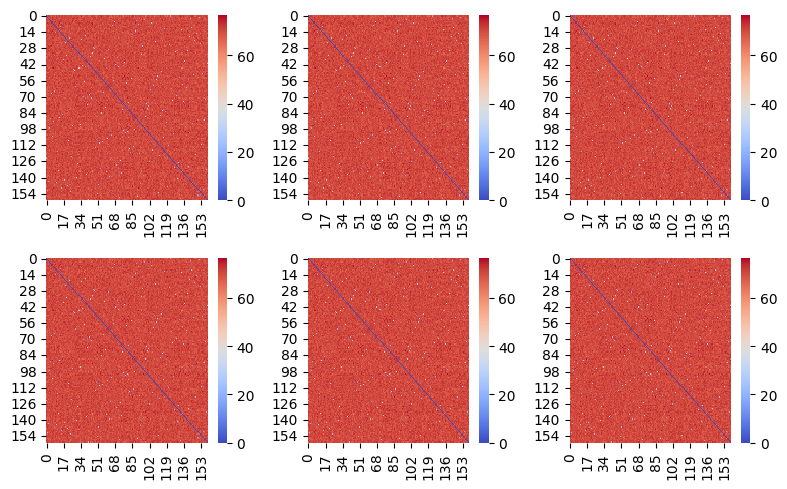

In [10]:
f, axs = plt.subplots(2, 3, figsize=(8, 5))

sns.heatmap(distances[ord[0]], annot=False, cmap='coolwarm', ax=axs[0, 0])
sns.heatmap(distances[ord[1]], annot=False, cmap='coolwarm', ax=axs[0, 1])
sns.heatmap(distances[ord[2]], annot=False, cmap='coolwarm', ax=axs[0, 2])
sns.heatmap(distances[ord[3]], annot=False, cmap='coolwarm', ax=axs[1, 0])
sns.heatmap(distances[ord[4]], annot=False, cmap='coolwarm', ax=axs[1, 1])
sns.heatmap(distances[ord[5]], annot=False, cmap='coolwarm', ax=axs[1, 2])
# sns.heatmap(distances[ord[6]], annot=False, cmap='coolwarm', ax=axs[2, 0])
# sns.heatmap(distances[ord[7]], annot=False, cmap='coolwarm', ax=axs[2, 1])
# sns.heatmap(distances[ord[8]], annot=False, cmap='coolwarm', ax=axs[2, 2])

plt.tight_layout()

# Эксперимент 1

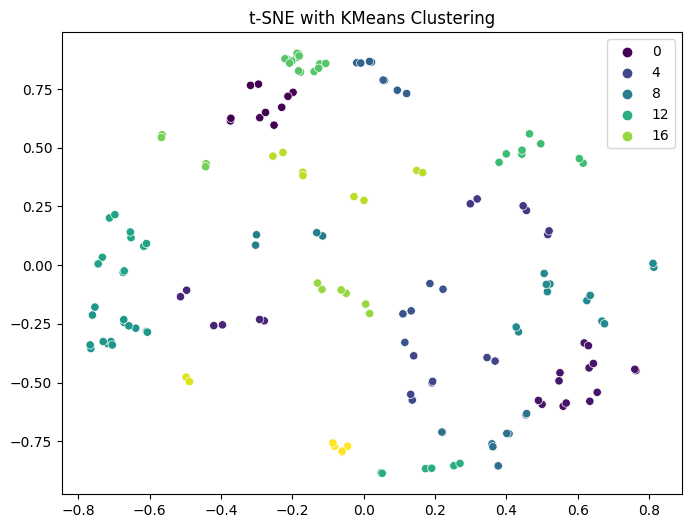

In [32]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(brainnetome.reshape(160, -1))

# Шаг 1: Применение t-SNE для снижения размерности
tsne = TSNE(random_state=42, perplexity=20,
            verbose=False,
            n_components = 2,
            early_exaggeration_iter= 300,
            early_exaggeration = 24,
            n_iter = 1000,
            exaggeration = 2,
            learning_rate = 100,
            metric = 'cosine',
            dof = 0.5,
            neighbors = 'pynndescent')
X_tsne = tsne.fit(X_scaled)

# Шаг 2: Применение KMeans для кластеризации
kmeans = KMeans(n_clusters=20, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Шаг 3: Визуализация результатов
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='viridis')
plt.title('t-SNE with KMeans Clustering')
plt.show()


In [33]:
Counter(labels)

Counter({10: 14,
         14: 14,
         16: 6,
         0: 10,
         4: 7,
         19: 6,
         13: 8,
         7: 10,
         5: 5,
         12: 6,
         3: 6,
         1: 14,
         9: 12,
         11: 10,
         8: 4,
         15: 4,
         2: 6,
         18: 2,
         17: 8,
         6: 8})

# Эксперимент 2
Тут я пробую сделать так:
1. Стандартизую отдельно `brainnetome` и `schaefer200` атласы
2. Отдельно сделаю `PCA` для них
3. Сконекчу их
4. Сделаю найду кластеры с `KMeans`
5. Уменьшу размерность и посмотрю на них с лейблами из `KMeans`

2 пункт можно заменить на другую технику понижения размерности: `UMAP`, `TSNE` 

In [42]:
scaler = StandardScaler()

pca_params = {
    'n_components' : 10,
    'random_state' : 42
}
pca = PCA(**pca_params)


data_scaled = data.copy()
for i in range(data[brainnetome_mask].shape[0]):
    scaler_b = StandardScaler()
    scaler_sch = StandardScaler()
    
    data_scaled[brainnetome_mask][i] = scaler.fit_transform(data[brainnetome_mask][i])
    data_scaled[schaefer200_mask][i] = scaler.fit_transform(data[schaefer200_mask][i])

data_pca = np.zeros((320, pca_params['n_components']))
for i in range(data[brainnetome_mask].shape[0]):
    data_pca[brainnetome_mask][i] = pca.fit_transform(data_scaled[brainnetome_mask][i]).mean(axis=0)
    data_pca[schaefer200][i] = pca.fit_transform(data_scaled[schaefer200][i]).mean(axis=0)



c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

IndexError: arrays used as indices must be of integer (or boolean) type

In [49]:
pca.fit_transform(data_scaled[brainnetome_mask][0]).mean(axis=0)

array([ 1.11022302e-15,  0.00000000e+00, -1.33226763e-16, -8.88178420e-17,
       -1.35447209e-15, -8.88178420e-17, -1.13242749e-15, -9.32587341e-16,
        2.05391260e-16,  1.30070788e-15])